# Getting Started with PyTorch
In this tutorial we will explore the fundamental capabilities of PyTorch using the MNIST dataset. We will cover key aspects of PyTorch, from loading data to building and training a simple neural network for classifying handwritten digits.

## What is PyTorch?
PyTorch is a popular library for numerical computations and building deep learning models. Developed by Facebook AI Research (FAIR), it provides a flexible platform for working with tensors, constructing, and training machine learning models.

## 1. Installation

```bash
pip install torch torchvision
```

## 2. Download MNIST dataset in local system

In [8]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

### We can print our datasets to see details

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Visualization of MNIST dataset
Lets print 5 random digits from the dataset!

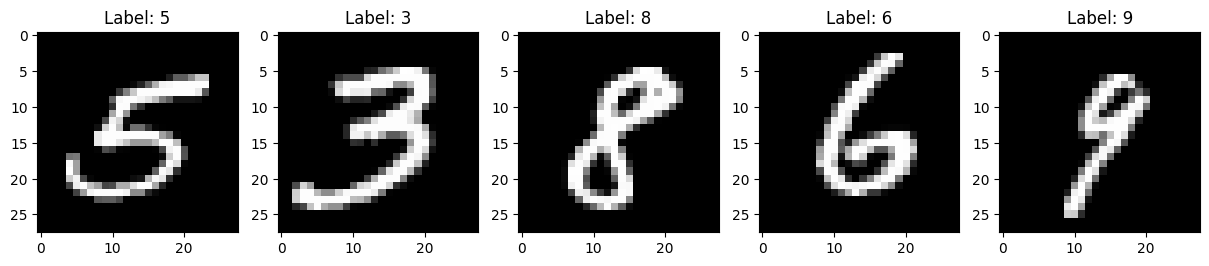

In [9]:
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(len(train_data)), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image, label = train_data[idx][0], train_data[idx][1]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title('Label: %i' % label)

plt.show()

## 3. Preparing data with DataLoaders
In PyTorch, a Dataset is responsible for fetching features and labels from our dataset one sample at a time. However, during the training of a model, it's common practice to process samples in "minibatches," shuffle the data at every epoch to mitigate model overfitting, and use multiprocessing to expedite data retrieval.

In [10]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

## 4. Define the Convolutional Neural Network model
This type of neural network is usded mainly in image procesing applications

### Parameters

- in_channels (int) — Number of channels in the input image
- out_channels (int) — Number of channels produced by the convolution
- kernel_size (int or tuple) — Size of the convolving kernel
- stride (int or tuple, optional) — Stride of the convolution. Default: 1
- padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0
- padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’
- dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1
- bias (bool, optional) — If True, adds a learnable bias to the output. Default: True
- groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

In [11]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x  

cnn = CNN()

## 5. Define loss function

In [12]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

## 6. Define a Optimization Function

In [13]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## 7. Training the model 
Create a function called train() and pass num of epochs, model and data loaders as input parameters.

In [14]:
from torch.autograd import Variable

num_epochs = 1

def train(num_epochs, cnn, loaders):
    cnn.train()
    
    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
train(num_epochs, cnn, loaders)

Epoch [1/1], Step [100/600], Loss: 0.1007
Epoch [1/1], Step [200/600], Loss: 0.0753
Epoch [1/1], Step [300/600], Loss: 0.0825
Epoch [1/1], Step [400/600], Loss: 0.1106
Epoch [1/1], Step [500/600], Loss: 0.0485
Epoch [1/1], Step [600/600], Loss: 0.0488


## 8. Evaluate the model on test data

In [17]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
test()

Test Accuracy of the model on the 10000 test images: 0.98


## 9. Print 10 predictions from test data

In [18]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [19]:
actual_number = lbls[:10].numpy()
actual_number

array([1, 5, 4, 4, 1, 2, 9, 6, 8, 4])

In [20]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [1 5 4 4 2 2 9 6 8 4]
Actual number: [1 5 4 4 1 2 9 6 8 4]
